## About this notebook

I've created this notebook to test a simple idea: what would happen if I used [prashantkikani's architecture](https://www.kaggle.com/prashantkikani/nfl-starter-mlp-feature-engg) with [miklgr500's solution](https://www.kaggle.com/miklgr500/fork-of-neural-networks-radam-repeatkfold)? 

The result was interesting, so I decided to share it. Hope it helps you to come up with new ideas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import keras
import gc
import math, string, os
gc.enable()
import re 

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

# Options
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


In [2]:
# Carregando os dados de treino
train = pd.read_csv('../data/train.csv', dtype={'WindSpeed': 'object'}, low_memory=False)
print ("Data is ready !!")

Data is ready !!


# Overall analysis

In [3]:
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


- Let's see how PlayId is distribuited

In [4]:
train['PlayId'].value_counts()

20181007011551    22
20181007090207    22
20171112053416    22
20170918003383    22
20181230140128    22
20170910022384    22
20171001120063    22
20181202132252    22
20171112090950    22
20171002002752    22
20170917041501    22
20170917051736    22
20181213001041    22
20180923012541    22
20181111021012    22
20180930094139    22
20181028023394    22
20171231153278    22
20181007023216    22
20180910011465    22
20170928000166    22
20181008001618    22
20171001102903    22
20181209030691    22
20181014100976    22
20181104072724    22
20181028040809    22
20180923113547    22
20171231100999    22
20181118081196    22
20171231031481    22
20180923003057    22
20181111060672    22
20171022113572    22
20170924073763    22
20180930073207    22
20181223144200    22
20171217101579    22
20181202080613    22
20170917104510    22
20181007033211    22
20171231130441    22
20180923061077    22
20171015011248    22
20171112012988    22
20171126103196    22
20171126033662    22
2017122407140

As expected, we have 22 of each playid since we have 22 players.

Let's look at our target variable(Yards).

In [5]:
train['Yards'].describe()

count    509762.000000
mean          4.212334
std           6.436167
min         -14.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          99.000000
Name: Yards, dtype: float64

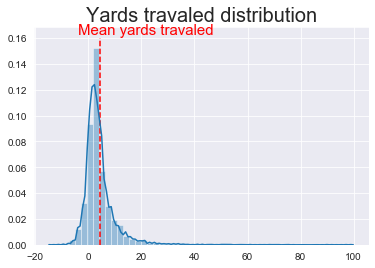

In [6]:
ax = sns.distplot(train['Yards'])
plt.vlines(train['Yards'].mean(), plt.ylim()[0], plt.ylim()[1], color='r', linestyles='--');
plt.text(train['Yards'].mean()-8, plt.ylim()[1]-0.005, "Mean yards travaled", size=15, color='r')
plt.xlabel("")
plt.title("Yards travaled distribution", size=20);

# Categorical features

In [7]:
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append((col, len(train[col].unique())))

Let's preprocess some of those features.

## Offense formation

In [8]:
off_form = train['OffenseFormation'].unique()
train['OffenseFormation'].value_counts()

SINGLEBACK    225434
SHOTGUN       150964
I_FORM        106062
PISTOL         13420
JUMBO          11462
WILDCAT         1782
EMPTY            506
ACE               22
Name: OffenseFormation, dtype: int64

Since I don't have any knowledge about formations, I am just goig to one-hot encode this feature

In [9]:
train = pd.concat([train.drop(['OffenseFormation'], axis=1), pd.get_dummies(train['OffenseFormation'], prefix='Formation')], axis=1)
dummy_col = train.columns

In [94]:
dummy_col

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffensePersonnel', 'DefendersInTheBox',
       'DefensePersonnel', 'PlayDirection', 'TimeHandoff', 'TimeSnap', 'Yards',
       'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate', 'PlayerCollegeName',
       'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Week', 'Stadium',
       'Location', 'StadiumType', 'Turf', 'GameWeather', 'Temperature',
       'Humidity', 'WindSpeed', 'WindDirection', 'Formation_ACE',
       'Formation_EMPTY', 'Formation_I_FORM', 'Formation_JUMBO',
       'Formation_PISTOL', 'Formation_SHOTGUN', 'Formation_SINGLEBACK',
       'Formation_WILDCAT'],
      dtype='object')

## Game Clock

Game clock is supposed to be a numerical feature.

In [10]:
train['GameClock'].value_counts()

15:00:00    14476
02:00:00     5236
14:54:00     2156
14:55:00     1958
14:56:00     1276
14:20:00     1188
14:25:00     1144
14:53:00     1078
14:24:00     1078
14:22:00     1056
01:54:00     1012
14:19:00      990
14:21:00      968
14:28:00      946
14:23:00      924
02:39:00      924
11:26:00      924
14:16:00      924
14:26:00      902
03:55:00      902
05:46:00      880
02:32:00      880
02:23:00      880
14:15:00      858
12:54:00      858
01:53:00      858
04:35:00      858
14:17:00      836
13:05:00      836
09:33:00      836
14:18:00      836
02:53:00      836
01:56:00      836
04:20:00      814
02:20:00      814
04:02:00      814
01:55:00      814
09:18:00      792
02:22:00      792
13:42:00      792
11:44:00      792
08:11:00      792
03:32:00      792
08:52:00      792
13:03:00      792
06:10:00      792
03:35:00      770
08:58:00      770
13:37:00      770
09:36:00      770
04:15:00      770
02:28:00      770
10:51:00      770
09:42:00      748
10:07:00      748
12:58:00  

Since we already have the quarter feature, we can just divide the Game Clock by 15 minutes so we can get the normalized time left in the quarter.

In [11]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

In [12]:
train['GameClock'] = train['GameClock'].apply(strtoseconds)

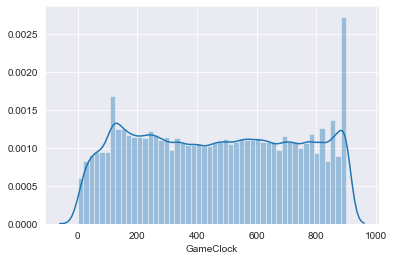

In [13]:
sns.distplot(train['GameClock'])

## Player height

In [14]:
train['PlayerHeight']

0          6-0
1          6-3
2          6-3
3          6-3
4          6-0
5          6-2
6         5-11
7          6-0
8          6-2
9          6-0
10         6-6
11        5-11
12         6-6
13         6-6
14         6-9
15         6-4
16         6-1
17        5-10
18        5-10
19         6-1
20         6-3
21         6-5
22         6-0
23         6-3
24         6-3
25         6-3
26         6-0
27         6-2
28        5-11
29         6-0
30         6-2
31         6-0
32         6-6
33        5-11
34         6-6
35         6-6
36         6-9
37         6-4
38         6-1
39        5-10
40        5-10
41         6-1
42         6-3
43         6-5
44         6-0
45         6-3
46         6-3
47         6-3
48         6-0
49         6-2
50        5-11
51         6-0
52         6-2
53         6-0
54         6-6
55        5-11
56         6-6
57         6-6
58         6-9
59         6-4
60         6-1
61        5-10
62        5-10
63         6-1
64         6-3
65         6-5
66        

We know that 1ft=12in, thus:

In [15]:
train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

## Time handoff and snap and Player BirthDate

In [16]:
train['TimeHandoff']

0         2017-09-08T00:44:06.000Z
1         2017-09-08T00:44:06.000Z
2         2017-09-08T00:44:06.000Z
3         2017-09-08T00:44:06.000Z
4         2017-09-08T00:44:06.000Z
5         2017-09-08T00:44:06.000Z
6         2017-09-08T00:44:06.000Z
7         2017-09-08T00:44:06.000Z
8         2017-09-08T00:44:06.000Z
9         2017-09-08T00:44:06.000Z
10        2017-09-08T00:44:06.000Z
11        2017-09-08T00:44:06.000Z
12        2017-09-08T00:44:06.000Z
13        2017-09-08T00:44:06.000Z
14        2017-09-08T00:44:06.000Z
15        2017-09-08T00:44:06.000Z
16        2017-09-08T00:44:06.000Z
17        2017-09-08T00:44:06.000Z
18        2017-09-08T00:44:06.000Z
19        2017-09-08T00:44:06.000Z
20        2017-09-08T00:44:06.000Z
21        2017-09-08T00:44:06.000Z
22        2017-09-08T00:44:27.000Z
23        2017-09-08T00:44:27.000Z
24        2017-09-08T00:44:27.000Z
25        2017-09-08T00:44:27.000Z
26        2017-09-08T00:44:27.000Z
27        2017-09-08T00:44:27.000Z
28        2017-09-08

In [17]:
train['TimeHandoff'] = train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
train['TimeSnap'] = train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

In [18]:
train['TimeDelta'] = train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)

In [19]:
train['PlayerBirthDate'] = train['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

Let's use the time handoff to calculate the players age

In [20]:
seconds_in_year = 60*60*24*365.25
train['PlayerAge'] = train.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)

In [21]:
train = train.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)

## Wind Speed and Direction

In [22]:
train['WindSpeed'].value_counts()

5                    53284
6                    41580
7                    39578
4                    34584
9                    31328
10                   29788
8                    29370
3                    26862
2                    24112
12                   23584
11                   17116
15                   13926
0                    13772
1                    12078
16                    9878
13                    8404
14                    6094
17                    3872
18                    1980
13 MPH                1804
23                    1166
E                     1144
SE                    1122
10-20                 1100
Calm                  1100
7 MPH                 1100
12-22                 1056
6 mph                 1034
20                    1012
14-23                  968
24                     968
12mph                  968
10mph                  902
4 MPh                  902
10MPH                  902
22                     836
SSW                    836
1

We can see there are some values that are not standardized(e.g. 12mph), we are going to remove mph from all our values.

In [23]:
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)

In [24]:
train['WindSpeed'].value_counts()

5                    53284
6                    42614
7                    40678
4                    35486
10                   31592
9                    31328
8                    29370
3                    26862
12                   24552
2                    24112
11                   17116
15                   13926
0                    13772
1                    12078
13                   10208
16                    9878
14                    6094
17                    3872
18                    1980
23                    1166
e                     1144
se                    1122
calm                  1100
10-20                 1100
12-22                 1056
20                    1012
24                     968
14-23                  968
ssw                    836
22                     836
15 gusts up to 25      836
11-17                  726
19                     660
Name: WindSpeed, dtype: int64

In [25]:
#let's replace the ones that has x-y by (x+y)/2
# and also the ones with x gusts up to y
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)

In [26]:
def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1

In [27]:
train['WindSpeed'] = train['WindSpeed'].apply(str_to_float)

In [28]:
train['WindDirection'].value_counts()

NE                 30250
NW                 27236
SW                 25828
SE                 25784
WSW                24222
N                  23188
W                  22198
S                  21384
NNE                20394
South              20328
SSW                19910
WNW                19118
North              17182
NNW                14036
West               13618
SSE                13376
E                  12826
ENE                10802
ESE                 9878
East                7348
Northwest           4070
From SW             3872
Northeast           3652
NorthEast           3212
From S              3146
s                   2728
SouthWest           2134
Southeast           1936
W-NW                1804
Southwest           1804
West-Southwest      1386
8                   1144
1                   1122
North East          1100
East Southeast      1078
Calm                1056
West Northwest      1056
N-NE                1012
From W               990
From SSW             968


The wind direction won't affect our model much because we are analyzing running plays so we are just going to drop it.

In [29]:
train.drop('WindDirection', axis=1, inplace=True)

## PlayDirection

In [30]:
train['PlayDirection'].value_counts()

left     256454
right    253308
Name: PlayDirection, dtype: int64

In [31]:
train['PlayDirection'] = train['PlayDirection'].apply(lambda x: x is 'right')

## Team

In [32]:
train['Team'] = train['Team'].apply(lambda x: x.strip()=='home')

## Game Weather

In [33]:
train['GameWeather'].unique()

array(['Clear and warm', 'Sun & clouds', 'Sunny', 'Controlled Climate',
       'Mostly Sunny', 'Clear', nan, 'Indoor', 'Mostly Cloudy',
       'Mostly Coudy', 'Partly sunny', 'Partly Cloudy', 'Cloudy',
       'Sunny, highs to upper 80s', 'Indoors', 'Light Rain', 'Showers',
       'Partly cloudy', 'Partly Sunny', '30% Chance of Rain',
       'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
       'Rain', 'Cloudy, fog started developing in 2nd quarter', 'Coudy',
       'Rain likely, temps in low 40s.', 'Cold', 'N/A (Indoors)',
       'Clear skies', 'cloudy', 'Fair', 'Mostly cloudy',
       'Cloudy, chance of rain', 'Heavy lake effect snow', 'Party Cloudy',
       'Cloudy, light snow accumulating 1-3"', 'Cloudy and cold', 'Snow',
       'Hazy', 'Scattered Showers', 'Cloudy and Cool', 'N/A Indoor',
       'Rain Chance 40%', 'Clear and sunny', 'Mostly sunny',
       'Sunny and warm', 'Partly clear', 'Cloudy, 50% change of rain',
       'Clear and Sunny', '

We are going to apply the following preprocessing:
 
- Lower case
- N/A Indoor, N/A (Indoors) and Indoor => indoor Let's try to cluster those together.
- coudy and clouidy => cloudy
- party => partly
- sunny and clear => clear and sunny
- skies and mostly => ""

In [34]:
train['GameWeather'] = train['GameWeather'].str.lower()
indoor = "indoor"
train['GameWeather'] = train['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)

In [35]:
train['GameWeather'].unique()

array(['clear and warm', 'sun & clouds', 'sunny', 'controlled climate',
       'clear', nan, 'indoor', 'cloudy', 'partly sunny', 'partly cloudy',
       'sunny, highs to upper 80s', 'light rain', 'showers',
       '30% chance of rain',
       'cloudy with periods of rain, thunder possible. winds shifting to wnw, 10-20 mph.',
       'rain', 'cloudy, fog started developing in 2nd quarter',
       'rain likely, temps in low 40s.', 'cold', 'fair',
       'cloudy, chance of rain', 'heavy lake effect snow',
       'cloudy, light snow accumulating 1-3"', 'cloudy and cold', 'snow',
       'hazy', 'scattered showers', 'cloudy and cool', 'rain chance 40%',
       'sunny and clear', 'sunny and warm', 'partly clear',
       'cloudy, 50% change of rain', 'sunny, windy', 'clear and cool',
       'overcast', 't: 51; h: 55; w: nw 10 mph', 'cloudy, rain',
       'rain shower', 'clear and cold', 'rainy', 'sunny and cold'],
      dtype=object)

Let's now look at the most common words we have in the weather description

In [36]:
from collections import Counter
weather_count = Counter()
for weather in train['GameWeather']:
    if pd.isna(weather):
        continue
    for word in weather.split():
        weather_count[word]+=1
        
weather_count.most_common()[:15]

[('cloudy', 193952),
 ('sunny', 127468),
 ('partly', 58256),
 ('clear', 55594),
 ('rain', 28952),
 ('indoor', 26950),
 ('controlled', 12540),
 ('climate', 12540),
 ('and', 10956),
 ('cloudy,', 4972),
 ('fair', 4972),
 ('snow', 4708),
 ('cold', 4510),
 ('of', 4026),
 ('light', 3608)]

To encode our weather we are going to do the following map:
 
- climate controlled or indoor => 3, sunny or sun => 2, clear => 1, cloudy => -1, rain => -2, snow => -3, others => 0
- partly => multiply by 0.5

I don't have any expercience with american football so I don't know if playing in a climate controlled or indoor stadium is good or not, if someone has a good idea on how to encode this it would be nice to leave it in the comments :)

In [37]:
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

In [38]:
train['GameWeather'] = train['GameWeather'].apply(map_weather)

## NflId NflIdRusher

In [39]:
train['IsRusher'] = train['NflId'] == train['NflIdRusher']

In [40]:
train.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)

In [41]:
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,Yards,PlayerHeight,PlayerWeight,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,Formation_ACE,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_WILDCAT,TimeDelta,PlayerAge,IsRusher
0,2017090700,20170907000118,False,73.91,34.84,1.69,1.13,0.40,81.99,177.18,Eric Berry,29,2017,35,1,854.0,NE,3,2,NE,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,8,72,212,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.692760,False
1,2017090700,20170907000118,False,74.67,32.64,0.42,1.35,0.01,27.61,198.70,Allen Bailey,97,2017,35,1,854.0,NE,3,2,NE,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,8,75,288,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.457305,False
2,2017090700,20170907000118,False,74.00,33.20,1.22,0.59,0.31,3.01,202.73,Justin Houston,50,2017,35,1,854.0,NE,3,2,NE,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,8,75,270,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.629790,False
3,2017090700,20170907000118,False,71.46,27.70,0.42,0.54,0.02,359.77,105.64,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,NE,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,8,75,245,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,34.795430,False
4,2017090700,20170907000118,False,69.32,35.42,1.82,2.43,0.16,12.63,164.31,Ron Parker,38,2017,35,1,854.0,NE,3,2,NE,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,8,72,206,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,30.061685,False


# Baseline model

Let's drop the categorical features and run a simple random forest in our model

In [42]:
train = train.sort_values(by=['PlayId', 'Team', 'IsRusher']).reset_index()

In [43]:
train.drop(['GameId', 'PlayId', 'index', 'IsRusher', 'Team'], axis=1, inplace=True)

In [44]:
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append(col)
        
train = train.drop(cat_features, axis=1)

In [45]:
train.head()

,X,Y,S,A,Dis,Orientation,Dir,JerseyNumber,Season,YardLine,Quarter,GameClock,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox,PlayDirection,Yards,PlayerHeight,PlayerWeight,Week,GameWeather,Temperature,Humidity,WindSpeed,Formation_ACE,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_WILDCAT,TimeDelta,PlayerAge
0,73.91,34.84,1.69,1.13,0.40,81.99,177.18,29,2017,35,1,854.0,3,2,0,0,6.0,False,8,72,212,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.692760
1,74.67,32.64,0.42,1.35,0.01,27.61,198.70,97,2017,35,1,854.0,3,2,0,0,6.0,False,8,75,288,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.457305
2,74.00,33.20,1.22,0.59,0.31,3.01,202.73,50,2017,35,1,854.0,3,2,0,0,6.0,False,8,75,270,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.629790
3,71.46,27.70,0.42,0.54,0.02,359.77,105.64,56,2017,35,1,854.0,3,2,0,0,6.0,False,8,75,245,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,34.795430
4,69.32,35.42,1.82,2.43,0.16,12.63,164.31,38,2017,35,1,854.0,3,2,0,0,6.0,False,8,72,206,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,30.061685


We are now going to make one big row for each play where the rusher is the last one

In [46]:
train_median = train.median()

In [47]:
train.fillna(train_median, inplace=True)

In [48]:
train.shape

(509762, 36)

In [49]:
train.head()

,X,Y,S,A,Dis,Orientation,Dir,JerseyNumber,Season,YardLine,Quarter,GameClock,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox,PlayDirection,Yards,PlayerHeight,PlayerWeight,Week,GameWeather,Temperature,Humidity,WindSpeed,Formation_ACE,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_WILDCAT,TimeDelta,PlayerAge
0,73.91,34.84,1.69,1.13,0.40,81.99,177.18,29,2017,35,1,854.0,3,2,0,0,6.0,False,8,72,212,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.692760
1,74.67,32.64,0.42,1.35,0.01,27.61,198.70,97,2017,35,1,854.0,3,2,0,0,6.0,False,8,75,288,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.457305
2,74.00,33.20,1.22,0.59,0.31,3.01,202.73,50,2017,35,1,854.0,3,2,0,0,6.0,False,8,75,270,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.629790
3,71.46,27.70,0.42,0.54,0.02,359.77,105.64,56,2017,35,1,854.0,3,2,0,0,6.0,False,8,75,245,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,34.795430
4,69.32,35.42,1.82,2.43,0.16,12.63,164.31,38,2017,35,1,854.0,3,2,0,0,6.0,False,8,72,206,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,30.061685


In [50]:
players_col = []
for col in train.columns:
    if train[col][:22].std()!=0:
        players_col.append(col)

In [51]:
train.shape

(509762, 36)

In [52]:
train.head()

,X,Y,S,A,Dis,Orientation,Dir,JerseyNumber,Season,YardLine,Quarter,GameClock,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox,PlayDirection,Yards,PlayerHeight,PlayerWeight,Week,GameWeather,Temperature,Humidity,WindSpeed,Formation_ACE,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_WILDCAT,TimeDelta,PlayerAge
0,73.91,34.84,1.69,1.13,0.40,81.99,177.18,29,2017,35,1,854.0,3,2,0,0,6.0,False,8,72,212,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.692760
1,74.67,32.64,0.42,1.35,0.01,27.61,198.70,97,2017,35,1,854.0,3,2,0,0,6.0,False,8,75,288,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.457305
2,74.00,33.20,1.22,0.59,0.31,3.01,202.73,50,2017,35,1,854.0,3,2,0,0,6.0,False,8,75,270,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,28.629790
3,71.46,27.70,0.42,0.54,0.02,359.77,105.64,56,2017,35,1,854.0,3,2,0,0,6.0,False,8,75,245,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,34.795430
4,69.32,35.42,1.82,2.43,0.16,12.63,164.31,38,2017,35,1,854.0,3,2,0,0,6.0,False,8,72,206,1,1.0,63.0,77.0,8.0,0,0,0,0,0,1,0,0,1.0,30.061685


In [55]:
ind_train = len(train)

In [58]:
#X_train = np.array(train[players_col]).reshape(-1, 11*22)
X_train = np.array(train[players_col]).reshape(ind_train//22, -1)

In [59]:
X_train.shape

(23171, 242)

In [60]:
play_col = train.drop(players_col+['Yards'], axis=1).columns
X_play_col = np.zeros(shape=(X_train.shape[0], len(play_col)))

In [61]:
play_col.shape, X_play_col.shape

((24,), (23171, 24))

In [62]:
for i, col in enumerate(play_col):
    X_play_col[:, i] = train[col][::22]

In [63]:
X_train = np.concatenate([X_train, X_play_col], axis=1)
y_train = np.zeros(shape=(X_train.shape[0], 199))
for i,yard in enumerate(train['Yards'][::22]):
    y_train[i, yard+99:] = np.ones(shape=(1, 100-yard))

In [98]:
def crps(y_true, y_pred):
    ans = 0
    ground_t = y_true.argmax(1)
    for i, t in enumerate(ground_t):
        for n in range(-99, 100):
            h = n>=(t-99)
            
            ans+=(y_pred[i][n+99]-h)**2
            
    return ans/(199*len(y_true))

In [65]:
from keras.callbacks import EarlyStopping

In [66]:
from keras import backend as K


__all__ = ['RAdam']


class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        learning_rate: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        learning_rate = kwargs.pop('lr', learning_rate)
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = K.maximum(self.total_steps - warmup_steps, 1)
            decay_rate = (self.min_lr - lr) / decay_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr + decay_rate * K.minimum(t - warmup_steps, decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t))
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t))

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / (v_corr_t + self.epsilon), m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, learning_rate):
        self.learning_rate = learning_rate

    def get_config(self):
        config = {
            'learning_rate': float(K.get_value(self.learning_rate)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [67]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout, Activation, PReLU, Add
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import metrics

In [ ]:
def give_me_model_1():
    numerical_inputs = Input(shape=(X_train.shape[1],)) 
    x = Dense(X_train.shape[1], activation='relu')(numerical_inputs)
    x = BatchNormalization()(x)
    
    logits = Dense(512,activation=None)(x)
    logits = PReLU()(logits)
    logits = Dropout(0.5)(logits)
    
    logits = Dense(512,activation=None)(logits)
    logits = PReLU()(logits)
    logits_ = logits
    logits = Dropout(0.5)(logits)
    
    logits = Dense(512,activation=None)(logits)
    logits = PReLU()(logits)
    logits = Add()([logits, logits_])
    logits = Dropout(0.6)(logits)
    
    out = Dense(199, activation='sigmoid')(logits)
    
    model = Model(inputs = numerical_inputs, outputs=out)
    return model

In [68]:
# Função para criar a estrutura da Rede Neural
def make_nn_model():
    numerical_inputs = Input(shape=(X_train.shape[1],)) 
    x = Dense(X_train.shape[1], activation='relu')(numerical_inputs)
    x = BatchNormalization()(x)
    
    logits = Dense(256,activation=None)(x)
    logits = PReLU()(logits)
    logits__ = logits
    logits = Dropout(0.5)(logits)
    
    logits = Dense(256,activation=None)(logits)
    logits = PReLU()(logits)
    logits_ = logits
    logits = Dropout(0.5)(logits)
    
    logits = Dense(256,activation=None)(logits)
    logits = PReLU()(logits)
    logits = Concatenate()([logits, logits_, logits__])
    logits = Dropout(0.25)(logits)
    
    out = Dense(199, activation='sigmoid')(logits)
    
    model = Model(inputs = numerical_inputs, outputs=out)
    return model

In [69]:
def train_model(x_tr, y_tr, x_vl, y_vl):
    model = make_nn_model()
    
    er = EarlyStopping(patience=10, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
    
    model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-7), loss='mse', metrics=[metrics.mae])
    model.fit(x_tr, y_tr, epochs=2, callbacks=[er], validation_data=[x_vl, y_vl])
    return model

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 

In [71]:
X_train.shape

(23171, 266)

In [97]:
missing_cols = set( dummy_col ) - set( test.columns )-set('Yards')
missing_cols

{'Formation_ACE',
 'Formation_EMPTY',
 'Formation_I_FORM',
 'Formation_JUMBO',
 'Formation_PISTOL',
 'Formation_SHOTGUN',
 'Formation_SINGLEBACK',
 'Formation_WILDCAT'}

In [72]:
# Funcao para realizar feature engineering no dataset (treino ou teste)
def feature_engineering(df): 
    df['OffenseFormation'] = df['OffenseFormation'].apply(lambda x: x if x in off_form else np.nan)
    df = pd.concat([df.drop(['OffenseFormation'], axis=1), pd.get_dummies(df['OffenseFormation'], prefix='Formation')], axis=1)
    
    
    missing_cols = set( dummy_col ) - set( test.columns )-set('Yards')
    for c in missing_cols:
        df[c] = 0
    df = df[dummy_col]
    
    df.drop(['Yards'], axis=1, inplace=True)
    df['GameClock'] = df['GameClock'].apply(strtoseconds)
    df['PlayerHeight'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
    df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
    seconds_in_year = 60*60*24*365.25
    df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(str_to_float)
    df['PlayDirection'] = train['PlayDirection'].apply(lambda x: x is 'right')
    df['Team'] = df['Team'].apply(lambda x: x.strip()=='home')
    indoor = "indoor"
    df['GameWeather'] = df['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.lower().replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly').replace('clear and sunny', 'sunny and clear').replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(map_weather)
    df['IsRusher'] = df['NflId'] == df['NflIdRusher']
    
    df = df.sort_values(by=['PlayId', 'Team', 'IsRusher']).reset_index()
    df = df.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate', 'WindDirection', 'NflId', 'NflIdRusher', 'GameId', 'PlayId', 'index', 'IsRusher', 'Team'], axis=1)
    cat_features = []
    for col in df.columns:
        if df[col].dtype =='object':
            cat_features.append(col)

    df = df.drop(cat_features, axis=1)
    df.fillna(train_median, inplace=True)
    return df

In [ ]:
#def make_pred(df, sample, env, models):
def make_pred(df, models):
    X = np.array(df[players_col]).reshape(-1, 11*22)
    play_col = df.drop(players_col, axis=1).columns
    X_play_col = np.zeros(shape=(X.shape[0], len(play_col)))
    for i, col in enumerate(play_col):
        X_play_col[:, i] = df[col][::22]
    X = scaler.transform(np.concatenate([X, X_play_col], axis=1))

    y_pred =np.array([model.predict(X) for model in models]).mean(0)
    for pred in y_pred:
        prev = 0
        for i in range(len(pred)):
            if pred[i]<prev:
                pred[i]=prev
            prev=pred[i]
    #env.predict(pd.DataFrame(data=y_pred,columns=sample.columns))
    return y_pred

In [73]:
# Funcao para realizar as previsoes no dataset de teste (neste caso simulacao)
def make_pred(df, models):
    X = np.array(df[players_col]).reshape(ind_test//22, -1)
    play_col = df.drop(players_col, axis=1).columns
    X_play_col = np.zeros(shape=(X.shape[0], len(play_col)))
    for i, col in enumerate(play_col):
        X_play_col[:, i] = df[col][::22]
    
    X = np.concatenate([X, X_play_col], axis=1)
    X = scaler.transform(X)

    y_pred = np.array([model.predict(X) for model in models]).mean(0)
    
    for pred in y_pred:
        prev = 0
        for i in range(len(pred)):
            print(pred[i])
            if pred[i]<prev:
                pred[i]=prev
            prev=pred[i]

    #env.predict(pd.DataFrame(data=y_pred,columns=sample.columns))
    return y_pred

In [78]:
from sklearn.model_selection import RepeatedKFold

#rkf = RepeatedKFold(n_splits=6, n_repeats=6)
rkf = RepeatedKFold(n_splits=2, n_repeats=2)

In [87]:
# Setup cross validation folds
from sklearn.model_selection import KFold
kf = 2
folds = KFold(n_splits=kf, shuffle=False)
print(str(kf) + ' Folds para treino...')

2 Folds para treino...


In [88]:
from keras import backend as K

In [89]:
K.clear_session()

In [92]:
models = []

#for tr_idx, vl_idx in rkf.split(X_train, y_train):
for fold_, (tr_idx, vl_idx) in enumerate(rkf.split(X_train, y_train)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    x_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    x_vl, y_vl = X_train[vl_idx], y_train[vl_idx]
    
    model = train_model(x_tr, y_tr, x_vl, y_vl)
    models.append(model)

fold 0
Train on 11585 samples, validate on 11586 samples
Epoch 1/2
11585/11585 [==============================] - 3s 269us/step - loss: 0.2961 - mean_absolute_error: 0.5007 - val_loss: 0.2779 - val_mean_absolute_error: 0.5050
Epoch 2/2
11585/11585 [==============================] - 3s 223us/step - loss: 0.2958 - mean_absolute_error: 0.5005 - val_loss: 0.2792 - val_mean_absolute_error: 0.5053
fold 1
Train on 11586 samples, validate on 11585 samples
Epoch 1/2
11586/11586 [==============================] - 3s 291us/step - loss: 0.2824 - mean_absolute_error: 0.4893 - val_loss: 0.2627 - val_mean_absolute_error: 0.4913
Epoch 2/2
11586/11586 [==============================] - 3s 235us/step - loss: 0.2824 - mean_absolute_error: 0.4894 - val_loss: 0.2632 - val_mean_absolute_error: 0.4911
fold 2
Train on 11585 samples, validate on 11586 samples
Epoch 1/2
11585/11585 [==============================] - 3s 279us/step - loss: 0.2998 - mean_absolute_error: 0.5056 - val_loss: 0.2783 - val_mean_absolut

In [ ]:
env = nflrush.make_env()

In [ ]:
for test, sample in tqdm.tqdm(env.iter_test()):
    make_pred(test, sample, env, models)

In [ ]:
env.write_submission_file()

In [93]:
# Carregando os dados de teste
test = pd.read_csv('../data/train.csv', low_memory=False)

# Aplicando Feature Engineering no dataset de teste
# Neste caso estou simulando 22 registros com os dados de treino
df_test = test.iloc[:22]
ind_test= len(df_test)

df_test = feature_engineering(df_test)

make_pred(df_test, models)

0.7141427
0.5384265
0.47978926
0.582616
0.4738215
0.5002964
0.37068102
0.5224639
0.5802828
0.47785622
0.4615589
0.512049
0.46350348
0.68968314
0.61132836
0.4860779
0.5322355
0.341502
0.4008729
0.64284706
0.5181408
0.5766133
0.54095745
0.49428546
0.56676495
0.43276358
0.4553775
0.5274036
0.49691224
0.57221097
0.46979517
0.6290237
0.51812655
0.53043234
0.49073493
0.3083975
0.56843084
0.56256396
0.37806547
0.6244863
0.54113364
0.579701
0.39404464
0.43765354
0.5551784
0.4550538
0.5551553
0.5025979
0.5210372
0.41999587
0.35187063
0.534374
0.49182218
0.5543055
0.56591135
0.4372609
0.4993385
0.55851465
0.51457214
0.53306687
0.4852932
0.34604323
0.45159125
0.5652425
0.48383236
0.5224828
0.35741457
0.5182515
0.6072397
0.45888358
0.5932832
0.60553384
0.6169381
0.40274507
0.61509925
0.49154538
0.57054186
0.5438348
0.44889304
0.5211564
0.47752887
0.39456648
0.4834145
0.5115522
0.51653534
0.46174145
0.4418621
0.5277787
0.37303865
0.5228267
0.57381624
0.41562068
0.6029501
0.5472114
0.5855782
0.38984

array([[0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427, 0.7141427,
        0.7141427, 0.7141427, 0.714142

# End

If you reached this far please comment and upvote this kernel, feel free to make improvements on the kernel and please share if you found anything useful!